# VALUE vs GROWTH DETECTION

This notebook contains all the code that will produce a model/signal to predict the optimum shift between value or growth investing.

_IMPORTS_

In [343]:
import os
import json
import pickle
import dotenv
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### LOAD DATA

In [281]:
root_dir = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(root_dir, "data")
dotenv_file = os.path.join(root_dir, '.env')

#loading all etfs data
with open (os.path.join(DATA_DIR, "etf_data", "us_etfs_list.pkl"), "rb") as f:
    etfs_list : dict = pickle.load(f)

#Load Commodities Futures Prices: .csv
commodities_dict = {}
commodities_files = os.listdir(os.path.join(DATA_DIR, "commodities"))
for f in commodities_files:
    commodities_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "commodities", f))

#Load Currencies Prices: .csv
currencies_dict = {}
currencies_files = os.listdir(os.path.join(DATA_DIR, "currencies"))
for f in currencies_files:
    currencies_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "currencies", f))

#FEDFUNDS and BALANCE: .pkl
macro_files = os.listdir(os.path.join(DATA_DIR, "macro_data"))
with open(os.path.join(DATA_DIR, "macro_data", "macro_data.pkl"), "rb") as f:
    macro_dict = pickle.load(f)


_Create Dataframes_

In [386]:
macro_dict

{'FEDFUNDS': 1954-07-01    0.80
 1954-08-01    1.22
 1954-09-01    1.07
 1954-10-01    0.85
 1954-11-01    0.83
               ... 
 2024-01-01    5.33
 2024-02-01    5.33
 2024-03-01    5.33
 2024-04-01    5.33
 2024-05-01    5.33
 Length: 839, dtype: float64,
 'IEABC': 1999-01-01    -60838.0
 1999-04-01    -67957.0
 1999-07-01    -76129.0
 1999-10-01    -81685.0
 2000-01-01    -94772.0
                 ...   
 2022-10-01   -216154.0
 2023-01-01   -212655.0
 2023-04-01   -214980.0
 2023-07-01   -196378.0
 2023-10-01   -194810.0
 Length: 100, dtype: float64}

In [408]:
start, end = "2014", "2024"

commodities_df = pd.concat(
    [
        pd.DataFrame(i).set_index(pd.DatetimeIndex(i["Date"],tz="utc"))["Close"] for i in commodities_dict.values()
    ],
    axis=1,
    ignore_index=True,
)
commodities_df.columns = ["Crude_Oil", "Gold", "Heating_Oil", "10Y_US_TBonds", "Corn"]
commodities_df = commodities_df.pct_change(1)
commodities_df = commodities_df[(commodities_df.index >= '2014-08-1') & (commodities_df.index <= '2024-06-01')]
commodities_df.index.tz_localize(None)
#___________________________________________________________________________
etfs_df = pd.concat(
    [
        pd.DataFrame(etfs_list["Growth"]["SPYG"]["price_history"])["Close"],
        pd.DataFrame(etfs_list["Value"]["SPYV"]["price_history"])["Close"]
    ],
    axis=1,
)
etfs_df.columns = ["SPYG", "SPYV"]
etfs_df = etfs_df.pct_change(1)
etfs_df = etfs_df[(etfs_df.index >= '2014-08-1') & (etfs_df.index <= '2024-06-01')]
#___________________________________________________________________________
macro_df = pd.DataFrame(macro_dict)
macro_df["IEABC"] = macro_df["IEABC"].pct_change(1)
macro_df = macro_df[(macro_df.index >= '2014-08-1') & (macro_df.index <= '2024-06-01')]
macro_df.dropna(inplace=True)
#___________________________________________________________________________

print("commodities", commodities_df.tail(1).index)
print("etfs data", etfs_df.tail(1).index)
print(macro_df.tail(1).index)

commodities DatetimeIndex(['2024-05-01 04:00:00+00:00'], dtype='datetime64[ns, UTC]', name='Date', freq=None)
etfs data DatetimeIndex(['2024-06-01 00:00:00-04:00'], dtype='datetime64[ns, America/New_York]', freq=None)
DatetimeIndex(['2024-05-01'], dtype='datetime64[ns]', freq='MS')


C:\Users\rvarg\AppData\Local\Temp\ipykernel_16976\885769790.py:27: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  macro_df["IEABC"] = macro_df["IEABC"].pct_change(1)


_Visualize Data_

Text(0.5, 1.0, 'Macro variables, Ir and Exports')

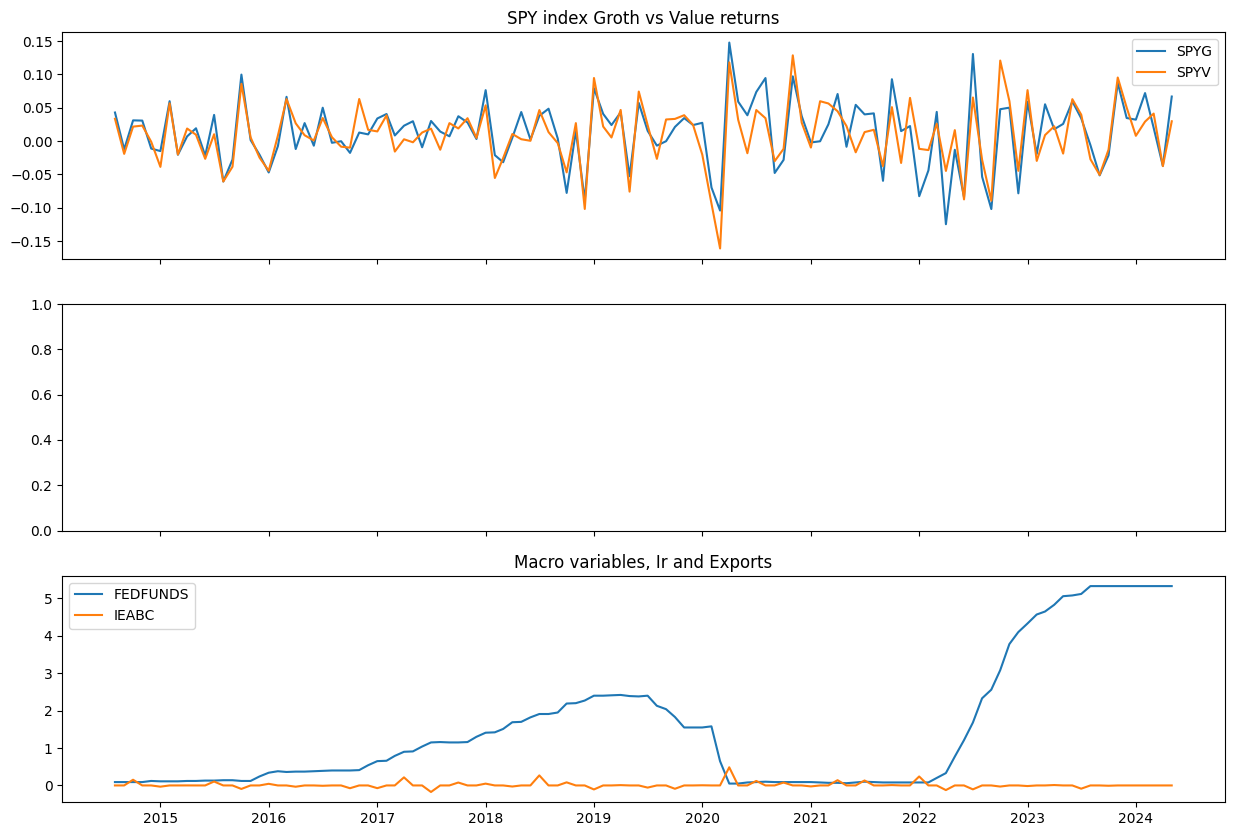

In [384]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)

#ETFs
axs[0].plot(etfs_df["SPYG"])
axs[0].plot(etfs_df["SPYV"])
axs[0].legend(["SPYG", "SPYV"])
axs[0].set_title("SPY index Groth vs Value returns")

#Commodities Futures
# axs[1].plot(commodities_df["Crude_Oil"])
# axs[1].plot(commodities_df["Gold"])
# axs[1].plot(commodities_df["Heating_Oil"])
# axs[1].plot(commodities_df["10Y_US_TBonds"])
# axs[1].plot(commodities_df["Corn"])
# axs[1].legend(commodities_df.columns)
# axs[1].set_title("Commodities Futures")

#Macro
axs[2].plot(macro_df["FEDFUNDS"])
axs[2].plot(macro_df["IEABC"])
axs[2].legend(macro_df.columns)
axs[2].set_title("Macro variables, Ir and Exports")

,SPYG,SPYV
2014-08-01 00:00:00-04:00,0.042747,0.033368
2014-09-01 00:00:00-04:00,-0.012491,-0.019254
2014-10-01 00:00:00-04:00,0.030972,0.021594
2014-11-01 00:00:00-04:00,0.030619,0.023148
2014-12-01 00:00:00-05:00,-0.011333,-0.001082
...,...,...
2024-02-01 00:00:00-05:00,0.071866,0.029085
2024-03-01 00:00:00-05:00,0.019654,0.041147
2024-04-01 00:00:00-04:00,-0.037264,-0.037665
2024-05-01 00:00:00-04:00,0.066695,0.029608
